In [1]:
import os
import sys

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from recpack.preprocessing.filters import MinItemsPerUser, MinUsersPerItem, Deduplicate
from recpack.datasets import MillionSongDataset

/Users/jens/PycharmProjects/minipack/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from minipack.scenarios import ProportionalStratifiedStrongGeneralization, StrongGeneralization

In [6]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

## Summary Statistics for Million Song Dataset

In [7]:
def import_dataset():
    dataset = MillionSongDataset(path='../data/', use_default_filters=False)    
    dataset.add_filter(MinUsersPerItem(200, dataset.ITEM_IX, dataset.USER_IX))
    dataset.add_filter(MinItemsPerUser(20, dataset.ITEM_IX, dataset.USER_IX))
    dataset.add_filter(Deduplicate(dataset.USER_IX, dataset.ITEM_IX))
    dataset.fetch_dataset()
    return dataset

In [8]:
dataset = import_dataset()
data = dataset.load()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 33633450/33633450 [00:13<00:00, 2542504.17it/s]


In [9]:
data.num_active_users

571355

In [10]:
data.num_interactions

33633450

In [11]:
data.num_active_items

41140

In [12]:
data.num_interactions / (data.num_active_users * data.num_active_items)

0.0014308730314171363

### User Statistics (All Data)

In [13]:
data._df.head()

,interactionid,uid,iid
0,0,0,0
1,1,0,1
2,2,0,2
3,3,0,3
4,4,0,4


In [14]:
interaction_count = data._df.groupby(['uid'])['iid'].count()

In [15]:
# 95% Quantile of Interactions
interaction_count.quantile(0.95)

156.0

95% of the user history legnths fall within the range [0, 156]. We create 5 bins between [0, 160] (rounded up for tidiness), which means we need bin widths of 32. Since we perform an 80-20% split for test in and test out data. We increase the bin width from 32 to 40 (32/0.8). This ensures that the data to be minimized (test in) has the number of interactions as defined by the bins.

In [16]:
interaction_count.describe()

count    571355.000000
mean         58.866117
std          53.579894
min          20.000000
25%          27.000000
50%          41.000000
75%          70.000000
max        1355.000000
Name: iid, dtype: float64

<Axes: xlabel='iid'>

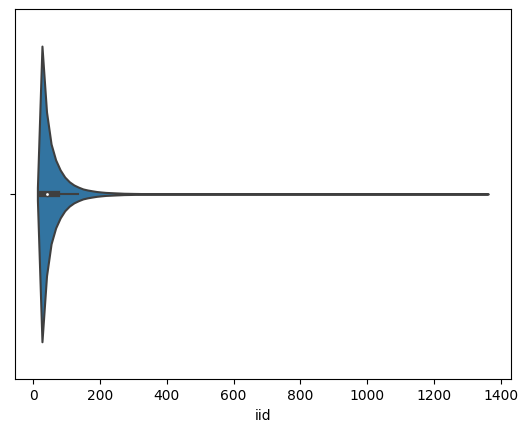

In [17]:
sns.violinplot(x=interaction_count)

### User Stratification (All Data)

/Users/jens/.pyenv/versions/3.11.8/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


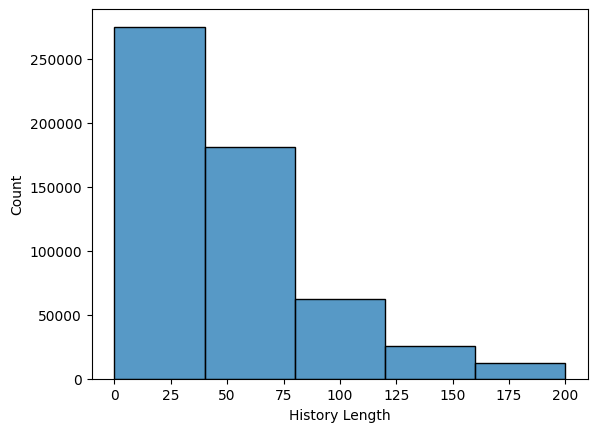

In [18]:
ax = sns.histplot(data=interaction_count, binwidth=40, binrange=[0, 200])
ax.set_ylabel("Count")
ax.set_xlabel("History Length")
plt.show()

In [19]:
# Calculating the number of users in each bin
bin_range = np.arange(0, 201, 40) 

In [20]:
# Calculating the number of users in each bin using pd.cut
users_per_bin = pd.cut(interaction_count, bins=bin_range, right=False)
users_per_bin = users_per_bin.value_counts().sort_index()

# Adjusting labels for clarity since the upper limit is exclusive
bin_labels = [f"[{bin_range[i]}, {bin_range[i+1]})" for i in range(len(bin_range)-1)]
users_per_bin.index = bin_labels

# Creating an integer index
# users_per_bin.index = range(len(users_per_bin))

print(users_per_bin)

[0, 40)       275296
[40, 80)      181241
[80, 120)      62315
[120, 160)     25470
[160, 200)     11971
Name: count, dtype: int64


In [21]:
# Generate bin indices and bin ranges
bin_indices = list(range(len(users_per_bin)))
bin_ranges = [f"[{bin_range[i]}, {bin_range[i+1]})" for i in range(len(bin_range)-1)]

# Calculate the total number of elements
total_count = users_per_bin.sum()

# Calculate the fraction of each bin compared to the whole
bin_fractions = users_per_bin / total_count

# Create a dictionary to hold the bin indices, counts, fractions, and ranges
bin_dict = {
    'bindex': bin_indices,
    'bin_range': bin_ranges,
    'bin_fraction': bin_fractions.values
}

# Convert dictionary to DataFrame (optional, if needed for merging later)
bin_df = pd.DataFrame(bin_dict)

print(bin_df)

   bindex   bin_range  bin_fraction
0       0     [0, 40)      0.494876
1       1    [40, 80)      0.325801
2       2   [80, 120)      0.112018
3       3  [120, 160)      0.045785
4       4  [160, 200)      0.021519


### Scenario

In [30]:
scenario = ProportionalStratifiedStrongGeneralization(num_users_test=50000, num_users_val=50000, num_users_est=1000, bin_width=40, bin_range=[0, 200], validation=True, estimation=True, seed=42)
scenario.split(data)

24743it [00:02, 9106.75it/s]
16290it [00:01, 9065.63it/s]
5600it [00:00, 8898.42it/s]
2289it [00:00, 8702.99it/s]
1078it [00:00, 8380.88it/s]
50000it [00:05, 8900.52it/s]
494it [00:00, 9177.58it/s]
325it [00:00, 9146.50it/s]
112it [00:00, 8030.53it/s]
45it [00:00, 6454.32it/s]
24it [00:00, 5825.42it/s]


In [31]:
full_train = scenario.full_training_data
val_train = scenario.validation_training_data
val_in = scenario.validation_data_in
val_out = scenario.validation_data_out
test_in = scenario.test_data_in
test_out = scenario.test_data_out

In [32]:
test_in.num_active_users

50000

In [33]:
val_in.num_active_users

50000

In [34]:
test_avg_interactions = test_in.num_interactions / test_in.num_active_users
test_avg_interactions

42.61178

In [35]:
data.num_interactions

33633450

### User Stratification (Test Data)

In [36]:
[test_data_bin.num_active_users for test_data_bin in scenario.test_data_in_bins]

[24743, 16290, 5600, 2289, 1078]

In [37]:
[test_data_bin.num_interactions / test_data_bin.num_active_users for test_data_bin in scenario.test_data_in_bins]

[22.61261771005941,
 45.04622467771639,
 77.23607142857144,
 109.70511140235911,
 142.5278293135436]